# Proyecto 3.B. Parte 4. Diseño de DSS en Empresa de Ventas en la Red: Feature Engineering

Vamos a intentar crear un modelo más preciso incluyendo nuevas features.

In [ ]:
!pip install bayesian-optimization
!pip install lightgbm
!pip install xgboost

In [ ]:
# Importamos paquetes basicos
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
from tqdm.notebook import tqdm

import sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier 
from sklearn.metrics import log_loss
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost.sklearn import XGBClassifier
from lightgbm.sklearn import LGBMClassifier

import pickle

# %matplotlib inline
plt.style.use('ggplot')
# Elimina la limitación en visualización del numero de columnas
pd.set_option('display.max_columns', None) 



## Cargamos la Base de Datos

In [ ]:
!wget https://github.com/IC1920/Datasets/raw/master/train.zip -O train.zip
!wget https://github.com/IC1920/Datasets/raw/master/test.zip -O test.zip
!unzip -o train.zip
!unzip -o test.zip

In [ ]:
# Leemos los archivos arff
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
print(df_train.shape, df_test.shape)

features = ['feat_'+str(i) for i in np.arange(1,94)]
target = 'target'

(61878, 95) (144368, 94)


## Preprocesado de la Base de Datos

Aunque a los árboles no les suele afectar en demasía que las variables tengan diferentes rangos, vamos a tipificar los datos con *Z-Score* para si vamos a usar otros algoritmos supervisados, como KNN, o no supervisados, como clústering.

In [ ]:
scaler = StandardScaler()
scaler.fit(df_train[features].values)
X_train_scaled = scaler.transform(df_train[features].values)
X_test_scaled = scaler.transform(df_test[features].values)

Preparamos las bases de datos. Para poder hacer una validación local, extraemos un 20% de forma aleatoria de forma estratificada.

In [ ]:
X_orig = X_train_scaled.copy()
y_orig = df_train[target].values.reshape(-1)
y_orig = LabelEncoder().fit_transform(y_orig)

X_train, X_val, y_train, y_val = train_test_split(X_orig, y_orig, test_size=0.20,
                                                  random_state=36, stratify=y_orig)

print("Verificamos que la partición es estratificada")
print(np.round(np.bincount(y_train)/len(y_train),3))
print(np.round(np.bincount(y_val)/len(y_val),3))

Verificamos que la partición es estratificada
[0.031 0.261 0.129 0.043 0.044 0.228 0.046 0.137 0.08 ]
[0.031 0.261 0.129 0.043 0.044 0.228 0.046 0.137 0.08 ]


## Creamos Nuevas Caracteristicas (Feature Engineering)

Una de las etapas más importantes dentro del *Machine Learning* es la creación de nuevas *Features* que 'expliquen' mejor el problema. En esta disciplina, denominada *Feature Engineering*, el conocimiento del dominio y la creatividad es fundamental.

En esta parte vamos a crear algunas *Features* usadas por @Giba en [la solución](https://www.kaggle.com/c/otto-group-product-classification-challenge/discussion/14335) que quedó en primera posición dentro de esta competición.

![](https://storage.googleapis.com/kaggle-forum-message-attachments/79598/2514/FINAL_ARCHITECTURE.png) 

La solución esta formada por un modelo stacking de tres niveles. En el nivel 1, se incluyen las predicciones de 33 modelos: modelos XGBoost, RandomForest, Árboles, KNN con diferentes valores de K, Redes neuronales, etc. Desarollados con R y Python. Además se incluyen valores de 8 Features.

La *Features* son las siguientes:
- Feature 1: Distances to nearest neighbours of each classes
- Feature 2: Sum of distances of 2 nearest neighbours of each classes
- Feature 3: Sum of distances of 4 nearest neighbours of each classes
- Feature 4: Distances to nearest neighbours of each classes in TFIDF space
- Feature 5: Distances to nearest neighbours of each classed in T-SNE space (3 dimensions)
- Feature 6: Clustering features of original dataset
- Feature 7: Number of non-zeros elements in each row
- Feature 8: X (That feature was used only in NN 2nd level training)

El nivel 1 está formado por tres tipos de modelos entrenados con el nivel 0: Un XGboost, una Red Neuronal y un modelo AdaBoost con árboles.

El nivel 2 es un promediado ponderado de la predicción de los tres modelos anteriores, tal y como muestra la figura.

Con intenciones didacticas, **vamos a intentar crear algunas *features* e incluirlas en el modelo de Stacking teniendo en cuenta que la información proporcionada en los foros es limitada**.

In [ ]:
# Poner a True para calcular las FEATS
CREA_FEATURES = False 

**ATENCION: El coste computacional del calculo de las características es muy alto. NO EJECUTAR EL CALCULO DE LAS FEATS SI NO SE DISPONE DE UN EQUIPO LOCAL DE ALTAS PRESTACIONES. El profesor ya ha calculado las carcaterísticas y dejado en un repositorio la base de datos con las features calculadas (ver punto 1.5).**

### Features 1, 2 y 3

Vamos a obtener la minima distancia de cada ejemplo con el vecino más cercano de cada clase, con los dos y con los cuatro vecinos: Features 1, 2, y 3 de la solución TOP.

In [ ]:
from multiprocessing import Pool
from scipy.spatial.distance import sqeuclidean

def f_train(nrow1):
    dist_1 = dict(zip(range(9),np.ones(9)*999999.9))
    dist_2 = dict(zip(range(9),np.ones(9)*999999.9))
    dist_4 = dict(zip(range(9),np.ones(9)*999999.9))
    dists = []
    for nrow2 in range(len(X_train_scaled)):
        dists.append(sqeuclidean(X_train_scaled[nrow1,:],X_train_scaled[nrow2,:]))
    dists = np.array(dists)
    dists = np.delete(dists, nrow1)
    y_orig_copy = y_orig.copy()
    y_orig_copy = np.delete(y_orig_copy, nrow1)
    for nclass in range(9):
        sort_y = np.sort(dists[y_orig_copy==nclass])
        dist_1[nclass] = sort_y[0]
        dist_2[nclass] = sort_y[0]+sort_y[1]
        dist_4[nclass] = sort_y[0]+sort_y[1]+sort_y[2]+sort_y[3]
    return np.array(list(dist_1.values())+list(dist_2.values())+list(dist_4.values())) 

def f_test(nrow1):
    dist_1 = dict(zip(range(9),np.ones(9)*999999.9))
    dist_2 = dict(zip(range(9),np.ones(9)*999999.9))
    dist_4 = dict(zip(range(9),np.ones(9)*999999.9))
    dists = []
    for nrow2 in range(len(X_train_scaled)):
        dists.append(sqeuclidean(X_test_scaled[nrow1,:],X_train_scaled[nrow2,:]))
    dists = np.array(dists)
    y_orig_copy = y_orig.copy()
    for nclass in range(9):
        sort_y = np.sort(dists[y_orig_copy==nclass])
        dist_1[nclass] = sort_y[0]
        dist_2[nclass] = sort_y[0]+sort_y[1]
        dist_4[nclass] = sort_y[0]+sort_y[1]+sort_y[2]+sort_y[3]
    return np.array(list(dist_1.values())+list(dist_2.values())+list(dist_4.values()))     

In [ ]:
%%time
if CREA_FEATURES:
    # Ejecuta en Paralelo
    p = Pool(processes=40)
    res_train = p.map_async(f_train, np.arange(len(X_train_scaled)))
    dist_train = np.array(res_train.get())
    res_test = p.map_async(f_test, np.arange(len(X_test_scaled)))
    dist_test = np.array(res_test.get())
    p.close()
    p.join()
    p.terminate()

CPU times: user 1min, sys: 1min 1s, total: 2min 1s
Wall time: 2h 47min 59s


In [ ]:
if CREA_FEATURES:
    if True:
        file = open('features123.pickle','wb')
        pickle.dump(dist_train, file, protocol=4)
        pickle.dump(dist_test, file, protocol=4)
        file.close()
    else:
        file = open('features123.pickle','rb')
        dist_train = pickle.load(file)
        dist_test = pickle.load(file)
        file.close()    

### Feature 4: Distances to nearest neighbours of each classes in TFIDF space

TFIDF corresponde con *term frequency–inverse document frequency*. Es un [estadistico](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) muy utilizado en *Text Mining* para la clasificación de documentos. **Indica la importancia de cada palabra dentro del documento considerando el numero de veces que aparece esa palabra en el documento pero considerando la frecuencia con que aparece en todos los documentos**. De este modo, palabras demasiado *comunes* no son significativas.

En la mejor solución, *Gilberto Titericz & Stanislav Semenov* **consideraron cada valor como si fuera una palabra diferente**. Una aproximación diferente que aunque no tiene mucho sentido si las variables son numericas, quizas puede ser interesante si algunos valores (o todos) corresponden a una escala categorica previamente definida por los analistas de OTTO.

Convertimos cada fila a un string fundiendo el valor de todas las columnas.

In [ ]:
if CREA_FEATURES:
    corpus_train = df_train[features].apply(lambda x: ' '.join(x.astype(str)),axis=1)
    corpus_test = df_test[features].apply(lambda x: ' '.join(x.astype(str)),axis=1)

Convertimos a TF-IDF.

In [ ]:
if CREA_FEATURES:
    from sklearn.feature_extraction.text import TfidfVectorizer
    vectorizer = TfidfVectorizer()
    vectorizer.fit(corpus_train)
    df_train_tfidf = vectorizer.transform(corpus_train).toarray()
    df_test_tfidf = vectorizer.transform(corpus_test).toarray()

    X_train_scaled = df_train_tfidf.copy()
    X_test_scaled = df_test_tfidf.copy()

In [ ]:
%%time
if CREA_FEATURES:
    # Ejecuta en Paralelo
    p = Pool(processes=40)
    res_train = p.map_async(f_train, np.arange(len(X_train_scaled)))
    dist_train_tfidf = np.array(res_train.get())
    res_test = p.map_async(f_test, np.arange(len(X_test_scaled)))
    dist_test_tfidf = np.array(res_test.get())
    p.close()
    p.join()
    p.terminate()

CPU times: user 21.3 s, sys: 10.9 s, total: 32.2 s
Wall time: 2h 55min 29s


In [ ]:
if CREA_FEATURES:
    if True:
        file = open('feature4.pickle','wb')
        pickle.dump(dist_train_tfidf, file, protocol=4)
        pickle.dump(dist_test_tfidf, file, protocol=4)
        file.close()
    else:
        file = open('feature4.pickle','rb')
        dist_train_tfidf = pickle.load(file)
        dist_test_tfidf = pickle.load(file)
        file.close()   

### Feature 5: Distances to nearest neighbours of each classed in T-SNE space (3 dimensions)

Esta caracteristica utiliza las distancias a cada clase usando la proyeccion t-SNE con tres componentes. Como no sabemos exactamente que parametros usaron en la proyeccion TSNE, vamos a basarnos en otro [kernel de esta misma competicion](https://www.kaggle.com/benhamner/t-sne-visualization-1) que consigue una proyeccion 2D muy interesante. En este caso, vamos a realizar una proyeccion con los mismos parametros pero para 3 dimensiones.

![](https://www.kaggleusercontent.com/kf/1912/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2In0..k_dAao_vsGDd_gQaW5wPvg.gCvodchVNT8yu94QGsSuTxdXs4js0m61cIFeKVfxk-xX5Iv1JfJcblYUVBv7HTW9M7ecQTXtEZMka_4FWwHC7eDcC7GShVAw9Haa4tk7Ie3j_uHHlC8grHA3yioDmHhtWhlZpom0W5NLldzyp1d-IA.wYXPJ_YJ63cei9mIGblKnQ/tsne.png)

In [ ]:
if CREA_FEATURES:
    from sklearn.manifold import TSNE
    X_tsne = np.vstack([df_train[features].values, df_test[features].values])
    print(X_tsne.shape)

    tsne_proj = TSNE(n_components=3, perplexity=30.0, angle=0.50, init='pca', random_state=0, n_jobs=-1)
    X_proj_tsne = tsne_proj.fit_transform(X_tsne)
    X_train_scaled = X_proj_tsne[:len(df_train),:]
    X_test_scaled = X_proj_tsne[len(df_train):,:]

In [ ]:
%%time
if CREA_FEATURES:
    # Ejecuta en Paralelo
    p = Pool(processes=40)
    res_train = p.map_async(f_train, np.arange(len(X_train_scaled)))
    dist_train_tsne = np.array(res_train.get())
    res_test = p.map_async(f_test, np.arange(len(X_test_scaled)))
    dist_test_tsne= np.array(res_test.get())
    p.close()
    p.join()
    p.terminate()

In [ ]:
if CREA_FEATURES:
    if True:
        file = open('feature5.pickle','wb')
        pickle.dump(dist_train_tsne, file, protocol=4)
        pickle.dump(dist_test_tsne, file, protocol=4)
        file.close()
    else:
        file = open('feature5.pickle','rb')
        dist_train_tsne = pickle.load(file)
        dist_test_tsne = pickle.load(file)
        file.close()   

### Feature 6: Clustering features of original dataset

No se indica que tecnica de cluster usaron. Vamos a utilizar el clasico *KMeans* aunque pueden utilizarse otros disponibles en *sklearn.cluster*.

In [ ]:
if CREA_FEATURES:
    from sklearn.cluster import KMeans

    scaler = StandardScaler()
    scaler.fit(df_train[features].values)
    X_train_scaled = scaler.transform(df_train[features].values)
    X_test_scaled = scaler.transform(df_test[features].values)

    X_kmeans = np.vstack([X_train_scaled, X_test_scaled])
    print(X_kmeans.shape)

    kmeans = KMeans(n_clusters=9, random_state=0).fit(X_kmeans)
    feature6 = kmeans.labels_.reshape((len(kmeans.labels_),1))
    feature6_train = feature6[:len(df_train),:]
    feature6_test = feature6[len(df_train):,:]
    print(feature6_train.shape, feature6_test.shape)

(206246, 93)

In [ ]:
if CREA_FEATURES:
    if True:
        file = open('feature6.pickle','wb')
        pickle.dump(feature6_train, file, protocol=4)
        pickle.dump(feature6_test, file, protocol=4)
        file.close()
    else:
        file = open('feature6.pickle','rb')
        feature6_train = pickle.load(file)
        feature6_test = pickle.load(file)
        file.close()  

### Feature 7: Number of non-zeros elements in each row

In [ ]:
if CREA_FEATURES:
    feature7_train = np.sum(df_train[features].values>0,axis=1).reshape((len(df_train),1))
    feature7_test = np.sum(df_test[features].values>0,axis=1).reshape((len(df_test),1))
    print(feature7_train.shape, feature7_test.shape)

In [ ]:
if CREA_FEATURES:
    if True:
        file = open('feature7.pickle','wb')
        pickle.dump(feature7_train, file, protocol=4)
        pickle.dump(feature7_test, file, protocol=4)
        file.close()
    else:
        file = open('feature7.pickle','rb')
        feature7_train = pickle.load(file)
        feature7_test = pickle.load(file)
        file.close()

### Creamos la Base de Datos con las nuevas features

In [ ]:
if CREA_FEATURES:
    if True:
        file = open('bd_stacking.pickle','wb')
        pickle.dump(df_train_stack, file, protocol=4)
        pickle.dump(df_test_stack, file, protocol=4)
        file.close()
    else:
        file = open('bd_stacking.pickle','rb')
        df_train_stack = pickle.load(file)
        df_test_stack = pickle.load(file)
        file.close()   

In [ ]:
if CREA_FEATURES:
    names_df = df_test_stack.columns

    X_train = np.hstack([df_train_stack[names_df].values.copy(),
                         dist_train,
                         dist_train_tfidf,
                         dist_train_tsne,
                         feature6_train,
                         feature7_train])

    X_test = np.hstack([df_test_stack[names_df].values.copy(),
                         dist_test,
                         dist_test_tfidf,
                         dist_test_tsne,
                         feature6_test,
                         feature7_test])                     
    X_train.shape, X_test.shape
    if True:
        file = open('bd_stacking_mas_feats.pickle','wb')
        pickle.dump(X_train, file, protocol=4)
        pickle.dump(X_test, file, protocol=4)
        file.close()
    else:
        file = open('bd_stacking_mas_feats.pickle','rb')
        X_train = pickle.load(file)
        X_test = pickle.load(file)
        file.close()   

((61878, 119), (144368, 119))

## Obtenemos las Bases de Datos con las Features Precalculadas

In [ ]:
!wget https://github.com/IC1920/Datasets/raw/master/bd_stacking.zip -O bd_stacking.zip
!wget https://github.com/IC1920/Datasets/raw/master/bd_stacking.z01 -O bd_stacking.z01
!wget https://github.com/IC1920/Datasets/raw/master/bd_stacking.z02 -O bd_stacking.z02

!7z x bd_stacking.zip -y

In [ ]:
# Cargamos la Base de Datos Previa de Stacking
if False:
    file = open('bd_stacking.pickle','wb')
    pickle.dump(df_train_stack, file, protocol=4)
    pickle.dump(df_test_stack, file, protocol=4)
    file.close()
else:
    file = open('bd_stacking.pickle','rb')
    df_train_stack = pickle.load(file)
    df_test_stack = pickle.load(file)
    file.close()   

df_train_stack.head()

In [ ]:
!wget https://github.com/IC1920/Datasets/raw/master/bd_stacking_mas_feats.zip -O bd_stacking_mas_feats.zip
!wget https://github.com/IC1920/Datasets/raw/master/bd_stacking_mas_feats.z01 -O bd_stacking_mas_feats.z01
!wget https://github.com/IC1920/Datasets/raw/master/bd_stacking_mas_feats.z02 -O bd_stacking_mas_feats.z02
!wget https://github.com/IC1920/Datasets/raw/master/bd_stacking_mas_feats.z03 -O bd_stacking_mas_feats.z03
!wget https://github.com/IC1920/Datasets/raw/master/bd_stacking_mas_feats.z04 -O bd_stacking_mas_feats.z04
!wget https://github.com/IC1920/Datasets/raw/master/bd_stacking_mas_feats.z05 -O bd_stacking_mas_feats.z05
    
!7z x bd_stacking_mas_feats.zip -y

In [ ]:
# Guardamos o cargamos la Base de Datos con las Features
if False:
    file = open('bd_stacking_mas_feats.pickle','wb')
    pickle.dump(X_train, file, protocol=4)
    pickle.dump(X_test, file, protocol=4)
    file.close()
else:
    file = open('bd_stacking_mas_feats.pickle','rb')
    X_train = pickle.load(file)
    X_test = pickle.load(file)
    file.close() 

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
X = X_train_scaled
y = df_train_stack['target'].values.reshape(-1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=36, stratify=y)

print("Verificamos que la partición es estratificada")
print(np.round(np.bincount(y_train)/len(y_train),3))
print(np.round(np.bincount(y_val)/len(y_val),3))

Verificamos que la partición es estratificada
[0.031 0.261 0.129 0.043 0.044 0.228 0.046 0.137 0.08 ]
[0.031 0.261 0.129 0.043 0.044 0.228 0.046 0.137 0.08 ]


## Buscamos un Modelo Stacking con XGBoost

In [ ]:
# Función que obtiene el LogLoss con repetición y para la base de datos de testeo
def entrena_model_folds(model, num_folds=5, num_bags=1, calibra=True, random_seed=2020):
    np.random.seed(random_seed)
    X_tot = X_orig.copy()
    y_tot = y_orig.copy()
    X_test = X_test_scaled.copy()
    
    # Creamos arrays para las predicciones
    preds_val = np.empty((len(X_tot), 9, num_bags))
    preds_val[:] = np.nan
    preds_test = np.empty((len(X_test), 9, num_bags*num_folds))
    preds_test[:] = np.nan
    
    # Entrena y extrae la predicciones con validación cruzada repetida
    folds = RepeatedStratifiedKFold(n_splits=num_folds, n_repeats=num_bags, random_state=random_seed)  
    for niter, (train_index, val_index) in enumerate(folds.split(X_tot, y_tot)):
        print('ITER=',niter)
        nbag = niter//num_folds #Extrae el número de repetición (bag)
        X_train, X_val = X_tot[train_index], X_tot[val_index]
        y_train, y_val = y_tot[train_index], y_tot[val_index]
        if calibra:
            calibrated_clf = CalibratedClassifierCV(model, method='isotonic', cv=5)
            calibrated_clf.fit(X_train, y_train)
            preds_val[val_index,:,nbag] = calibrated_clf.predict_proba(X_val) 
            preds_test[:,:,niter] = calibrated_clf.predict_proba(X_test)
        else:
            model.fit(X_train, y_train)
            preds_val[val_index,:,nbag] = model.predict_proba(X_val) 
            preds_test[:,:,niter] = model.predict_proba(X_test)
        
    # Promedia las predicciones
    preds_val_mean = preds_val.mean(axis=2) 
    preds_test_mean = preds_test.mean(axis=2)

    # Extrae las métricas
    log_loss_val = log_loss(y_tot, preds_val_mean, eps=1e-15, normalize=True)
    return log_loss_val, y_tot, preds_val_mean, preds_test_mean

In [ ]:
def entrena_model_hold_out(model, calibra=True, random_seed=1234):
    np.random.seed(random_seed)
    if calibra:
        calibrated_clf = CalibratedClassifierCV(model, method='isotonic', cv=5)
        calibrated_clf.fit(X_train, y_train)
        preds_val = calibrated_clf.predict_proba(X_val)
    else:
        model.fit(X_train, y_train)
        preds_val = model.predict_proba(X_val)

    # Extrae las métricas
    log_loss_val = log_loss(y_val, preds_val, eps=1e-15, normalize=True)
    return log_loss_val

In [ ]:
def busca_param(valores, nombre_var, parametros, random_seed=1234, cv=5):
    scores = []
    for valor in tqdm(valores):
        parametros[nombre_var]=valor
        xgb_model = XGBClassifier(learning_rate=parametros['learning_rate'],
                                  n_estimators=parametros['n_estimators'],
                                  max_depth=parametros['max_depth'],
                                  subsample=parametros['subsample'],
                                  colsample_bytree=parametros['colsample_bytree'],
                                  reg_alpha=parametros['reg_alpha'], 
                                  reg_lambda=parametros['reg_lambda'],
                                  nthread=20, 
                                  seed=random_seed, objective='multi:softprob')
        log_loss_val = entrena_model_hold_out(xgb_model, calibra=True, random_seed=random_seed)
        print(f'{nombre_var}={valor} log_loss_val={log_loss_val}')
        scores.append(log_loss_val)
    plt.plot(valores,scores,'o-')
    plt.ylabel('log_loss_val')
    plt.xlabel(nombre_var)
    print(f'Mejor {nombre_var}={valores[np.argmin(scores)]} Score={np.min(scores)}')
    return valores[np.argmin(scores)]

In [ ]:
# Parametros que vienen por defecto
parametros = {'learning_rate':0.1, 'n_estimators':100, 'max_depth':6,
              'subsample':0.80, 'colsample_bytree':0.80,
              'reg_alpha':0.0, 'reg_lambda':1.0}

/home/edmans/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


n_estimators=25 log_loss_val=0.4235074776922197
n_estimators=50 log_loss_val=0.41696549937893984
n_estimators=75 log_loss_val=0.4149248595158798
n_estimators=100 log_loss_val=0.41227988112093217
n_estimators=125 log_loss_val=0.41410056215856184
n_estimators=150 log_loss_val=0.4144086168898671
n_estimators=175 log_loss_val=0.4120861569096881
n_estimators=200 log_loss_val=0.4125679265989554
n_estimators=225 log_loss_val=0.4127574425348715
n_estimators=250 log_loss_val=0.41263665991311316
n_estimators=275 log_loss_val=0.4147394989383713
n_estimators=300 log_loss_val=0.41550100367179266
n_estimators=325 log_loss_val=0.4158360479008373
n_estimators=350 log_loss_val=0.41573235126162705
n_estimators=375 log_loss_val=0.41648877444745075
n_estimators=400 log_loss_val=0.4163368657983821
n_estimators=425 log_loss_val=0.41652483537696444
n_estimators=450 log_loss_val=0.4172293819984552
n_estimators=475 log_loss_val=0.41689096217036986

Mejor n_estimators=175 Score=0.4120861569096881
{'learning_rat

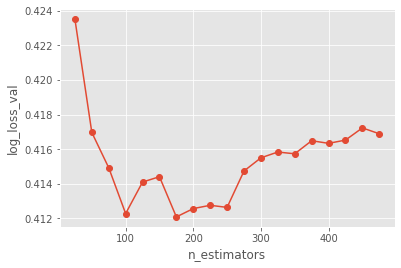

In [ ]:
# Busqueda del numero de arboles
parametros['n_estimators'] = busca_param(np.arange(25,500,25), 'n_estimators', parametros)
print(parametros)

/home/edmans/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


max_depth=2 log_loss_val=0.41554423726095957
max_depth=3 log_loss_val=0.4154237812543314
max_depth=4 log_loss_val=0.4140361454977894
max_depth=5 log_loss_val=0.415187951445936
max_depth=6 log_loss_val=0.4120861569096881
max_depth=7 log_loss_val=0.4147368125978941
max_depth=8 log_loss_val=0.4118496650302832
max_depth=9 log_loss_val=0.41409615157228125
max_depth=10 log_loss_val=0.4133072333278748
max_depth=11 log_loss_val=0.4131769442063628
max_depth=12 log_loss_val=0.416036728822314
max_depth=13 log_loss_val=0.4174964019111972
max_depth=14 log_loss_val=0.41671922726311217

Mejor max_depth=8 Score=0.4118496650302832
{'learning_rate': 0.1, 'n_estimators': 175, 'max_depth': 8, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.0, 'reg_lambda': 1.0}


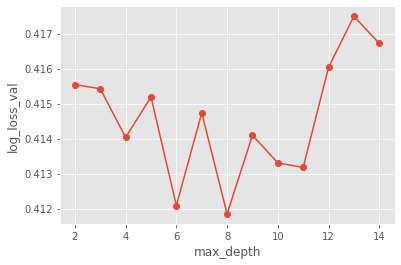

In [ ]:
parametros['max_depth'] = busca_param(np.arange(2,15), 'max_depth', parametros)
print(parametros)

/home/edmans/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


subsample=0.1 log_loss_val=0.424382108290362
subsample=0.2 log_loss_val=0.4172689070081885
subsample=0.3 log_loss_val=0.41772649210810125
subsample=0.4 log_loss_val=0.4175670142185921
subsample=0.5 log_loss_val=0.41343495659406115
subsample=0.6 log_loss_val=0.41238517856519247
subsample=0.7 log_loss_val=0.4124910546943448
subsample=0.8 log_loss_val=0.4118496650302832
subsample=0.9 log_loss_val=0.4121708782512237
subsample=1.0 log_loss_val=0.4125805130987297

Mejor subsample=0.8 Score=0.4118496650302832
{'learning_rate': 0.1, 'n_estimators': 175, 'max_depth': 8, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.0, 'reg_lambda': 1.0}


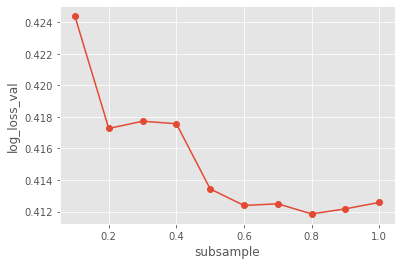

In [ ]:
parametros['subsample'] = busca_param(np.arange(1,11)/10.0, 'subsample', parametros)
print(parametros)

/home/edmans/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


colsample_bytree=0.1 log_loss_val=0.4179915210890933
colsample_bytree=0.2 log_loss_val=0.4128895777147414
colsample_bytree=0.3 log_loss_val=0.4111063640370451
colsample_bytree=0.4 log_loss_val=0.4121806347327324
colsample_bytree=0.5 log_loss_val=0.4113263515227521
colsample_bytree=0.6 log_loss_val=0.4138769780716461
colsample_bytree=0.7 log_loss_val=0.4140690617983633
colsample_bytree=0.8 log_loss_val=0.4118496650302832
colsample_bytree=0.9 log_loss_val=0.41274330785282237
colsample_bytree=1.0 log_loss_val=0.4145195131599581

Mejor colsample_bytree=0.3 Score=0.4111063640370451
{'learning_rate': 0.1, 'n_estimators': 175, 'max_depth': 8, 'subsample': 0.8, 'colsample_bytree': 0.3, 'reg_alpha': 0.0, 'reg_lambda': 1.0}


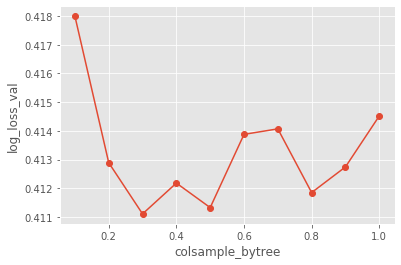

In [ ]:
parametros['colsample_bytree'] = busca_param(np.arange(1,11)/10.0, 'colsample_bytree', parametros)
print(parametros)

/home/edmans/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


reg_alpha=0.0 log_loss_val=0.4111063640370451
reg_alpha=0.0001 log_loss_val=0.4128689814716297
reg_alpha=0.001 log_loss_val=0.4129633877896897
reg_alpha=0.01 log_loss_val=0.41390576355281783
reg_alpha=0.1 log_loss_val=0.41398074373879673
reg_alpha=1.0 log_loss_val=0.41418430406072565
reg_alpha=10 log_loss_val=0.41378374183554556

Mejor reg_alpha=0.0 Score=0.4111063640370451
{'learning_rate': 0.1, 'n_estimators': 175, 'max_depth': 8, 'subsample': 0.8, 'colsample_bytree': 0.3, 'reg_alpha': 0.0, 'reg_lambda': 1.0}


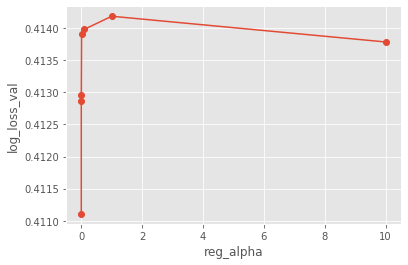

In [ ]:
# Probamos con Regularización L1
parametros['reg_alpha'] = busca_param([0.0, 0.0001, 0.001, 0.01, 0.1, 1.0, 10], 'reg_alpha', parametros)
print(parametros)

/home/edmans/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


reg_lambda=0.0001 log_loss_val=0.41248080783090113
reg_lambda=0.001 log_loss_val=0.41080411200275674
reg_lambda=0.01 log_loss_val=0.41093449497861384
reg_lambda=0.1 log_loss_val=0.41196826352312266
reg_lambda=1.0 log_loss_val=0.4111063640370451
reg_lambda=10 log_loss_val=0.4135227228489155

Mejor reg_lambda=0.001 Score=0.41080411200275674
{'learning_rate': 0.1, 'n_estimators': 175, 'max_depth': 8, 'subsample': 0.8, 'colsample_bytree': 0.3, 'reg_alpha': 0.0, 'reg_lambda': 0.001}


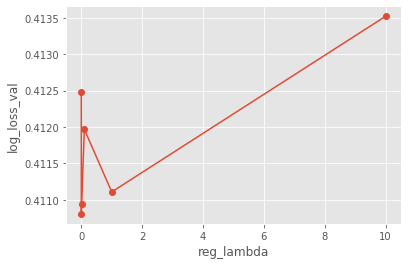

In [ ]:
# Probamos con Regularización L2
parametros['reg_lambda'] = busca_param([0.0001, 0.001, 0.01, 0.1, 1.0, 10], 'reg_lambda', parametros)
print(parametros)

/home/edmans/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


n_estimators=100 log_loss_val=0.4140007602311357
n_estimators=110 log_loss_val=0.41349865125477836
n_estimators=120 log_loss_val=0.4110390458141529
n_estimators=130 log_loss_val=0.41077174057426563
n_estimators=140 log_loss_val=0.4107615427945567
n_estimators=150 log_loss_val=0.410834136305217
n_estimators=160 log_loss_val=0.4112461448258901
n_estimators=170 log_loss_val=0.41101305052559034
n_estimators=180 log_loss_val=0.4105700994956231
n_estimators=190 log_loss_val=0.4127619167941956
n_estimators=200 log_loss_val=0.4126119152345719
n_estimators=210 log_loss_val=0.412557477332704
n_estimators=220 log_loss_val=0.4125947356594967
n_estimators=230 log_loss_val=0.41261487822322723
n_estimators=240 log_loss_val=0.41289754152948327

Mejor n_estimators=180 Score=0.4105700994956231
{'learning_rate': 0.1, 'n_estimators': 180, 'max_depth': 8, 'subsample': 0.8, 'colsample_bytree': 0.3, 'reg_alpha': 0.0, 'reg_lambda': 0.001}


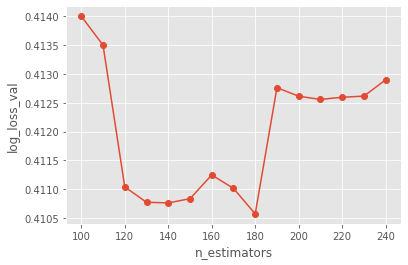

In [ ]:
parametros['n_estimators'] = busca_param(np.arange(parametros['n_estimators']-75,parametros['n_estimators']+75,10),
                                         'n_estimators', parametros)
print(parametros)

## Creamos la Submission con el Modelo Stacking

In [ ]:
X_orig = X_train_scaled.copy()
y_orig = y.copy()

In [ ]:
%%time
random_seed = 1234
stack_model = XGBClassifier(learning_rate=parametros['learning_rate'],
                                  n_estimators=parametros['n_estimators'],
                                  max_depth=parametros['max_depth'],
                                  subsample=parametros['subsample'],
                                  colsample_bytree=parametros['colsample_bytree'],
                                  reg_alpha=parametros['reg_alpha'], 
                                  reg_lambda=parametros['reg_lambda'],
                                  nthread=20, 
                                  seed=random_seed, objective='multi:softprob')
loss_stack, y_stack, preds_val_stack, preds_test_stack  = entrena_model_folds(stack_model, 
                                                                              calibra=True, 
                                                                              random_seed=random_seed)
print('STACKING MODEL=',loss_stack)

ITER= 0
ITER= 1
ITER= 2
ITER= 3
ITER= 4
STACKING MODEL= 0.4204436336446902
CPU times: user 4h 27min 46s, sys: 5min 9s, total: 4h 32min 55s
Wall time: 13min 40s


In [ ]:
output = pd.DataFrame(preds_test_stack,columns=["Class_"+str(i) for i in range(1,10)])
output.insert(loc=0, column='id', value=df_test.id)
output.to_csv('submission_stacking_with_features_5cv.csv', index=False)
pd.read_csv('submission_stacking_with_features_5cv.csv').head()

,id,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9
0,1,0.000166,0.071966,0.085833,0.835622,0.000000,0.000069,0.006216,0.000075,0.000053
1,2,0.007548,0.005456,0.002795,0.002268,0.000261,0.418204,0.013598,0.538994,0.010876
2,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.999937,0.000000,0.000063,0.000000
3,4,0.000110,0.627135,0.360822,0.011343,0.000000,0.000081,0.000132,0.000170,0.000208
4,5,0.043405,0.000082,0.000111,0.000162,0.000000,0.002661,0.000320,0.014462,0.938797


El modelo stacking con unas características basadas en la solucion TOP obtiene con 5CV un **Local=0.0.4204436336446902, Private_LB=0.40993, Public_LB=0.40883, que nos situaria en la posición 42 del Private Leaderboard de 3511 equipos (percentil 98.80) dándonos una MEDALLA DE PLATA y acercándonos a las primeras posiciones**.

**EJERCICIO 3.B.4: Incluir las predicciones del modelo LightGBM y recalcular el modelo de Stacking.**

**ATENCION: Para reducir los tiempos de entrenamiento es recomendable reducir los rangos de búsqueda de los parámetros basándose en los mejores valores obtenidos con el anterior modelo de Stacking**

**Crear la submission y presentar los Scores Finales Publicos y Privados. Comparar los resultados con y sin LGB** 

**Incluir en este script una foto de la pantalla de Kaggle con los resultados de la submission y en que posición del PRIVATE LEADERBOARD quedaria.**

In [ ]:
#dataframes con las clases de lgb
df_train = pd.read_csv('/content/df_test_lgb.csv')
df_test = pd.read_csv('/content/df_test_lgb.csv')

**EJERCICIO 3.B.5: Te atreves a incluir nuevas features?**

**Investiga en el foro de la competicion de Kaggle e intenta incluir dos nuevas features.**

**Recalcular el modelo stacking**

**Hasta donde eres capaz de llegar? Te atreves a combinar otros modelos en el segundo nivel?**

**Incluir en este script una foto de la pantalla de Kaggle con los resultados de la submission y en que posición del PRIVATE LEADERBOARD quedarias.**

# ENTREGA

Recuerda guardar tus cambios en tu repositorio utilizando la opción "Save a copy in GitHub..." del menú File.